In [1]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dataorganizer)
  library(dplyr)
  library(magrittr)
  library(Matrix)
  library(readr)
  library(ggplot2)
  library(Seurat)
  library(sccore)
  library(patchwork)
})

theme_set(theme_bw())

## Load data

In [2]:
cell_meta <- DatasetPath(
  'human_ovarian_cancer', 'seg_method_results', 'bidcell', 'cell_gene_matrices', 
  '2025_01_16_22_15_56', 'cell_meta.csv'
) %>% read.csv() %>% set_rownames(paste0('Cell_', .$cell_id))

In [3]:
cm <- DatasetPath(
  'human_ovarian_cancer', 'seg_method_results', 'bidcell', 'cell_gene_matrices', 
  '2025_01_16_22_15_56', 'expr_mat.csv'
) %>% data.table::fread() %>% .[,3:ncol(.)] %>% as.matrix() %>% as('dgCMatrix') %>% t()

so <- CreateSeuratObject(cm) %>% 
    subset(cells=rownames(cell_meta))

so@meta.data <- cbind(so@meta.data, cell_meta[colnames(so),])

so

An object of class Seurat 
4912 features across 300713 samples within 1 assay 
Active assay: RNA (4912 features, 0 variable features)
 1 layer present: counts

In [4]:
so[['spatial']] <- so@meta.data %>%
  select(x, y) %>% as.matrix() %>%
  set_colnames(c('spatial_1', 'spatial_2')) %>%
  CreateDimReducObject(key='spatial_', assay='RNA')

In [5]:
so$cell_type_full <- so$cell_type
so$cell_type[grep('Tumor Cells', so$cell_type_full)] <- 'Tumor Cells'

## Process

In [6]:
so %<>%
  NormalizeData() %>%
  FindVariableFeatures(selection.method="vst", nfeatures=2000) %>%
  ScaleData() %>%
  RunPCA(., features=VariableFeatures(.)) %>%
  FindNeighbors(dims=1:30) %>%
  RunUMAP(dims=1:30, n.epochs=500) %>%
  FindClusters(resolution=2, algorithm=2)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  MYH11, C11orf96, C7, DCN, CNN1, POSTN, CDKN1A, NR4A1, CCN1, LUM 
	   COL5A1, BGN, AQP1, SFRP4, C4B, PDGFRB, SYNPO2, CXCL12, SLC2A3, AOC3 
	   ABCA8, PLN, CCND2, SOCS3, THY1, TNXB, SMOC2, ADGRA2, ZEB2, PRRX1 
Negative:  CD47, LAPTM4B, PRKCI, UCHL1, HSPD1, CP, EPCAM, YWHAZ, HMGA1, PLXNB1 
	   HSPE1, MLF1, SMC4, LCN2, MUC16, IFT57, TPX2, CYP4B1, TFRC, TOP2A 
	   ALCAM, DSG2, BIRC5, MAL2, CSE1L, IL1RAP, DHCR24, TMEM123, STMN1, SOX17 
PC_ 2 
Positive:  BGN, COL5A1, LUM, MMP14, COL5A2, CTHRC1, THY1, THBS2, COL11A1, COL4A1 
	   CDH11, PLAU, POSTN, DCN, LOXL1, INHBA, ADAMTS14, SERPINH1, FAP, SERPINE1 
	   CXCL12, ADAM12, TIMP3, HOPX, SNAI2, CCN4, LTBP2, CCN2, COL4A2, LOX 
Negative:  MYH11, CNN1, CP, MUC16, CYP4B1, RGL3, EPCAM, LCN2, PLXNB1, CD47 
	   ADAMTS1, C2orf88, PRKCI, MAL2, UGT2B7, MLF1, SCNN1A, PAX8, LPAR3, SLC5A3 
	   KLHL14, ERBB3, PCP2, KCNC3, RBM38, THSD4, CEL

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 300713
Number of edges: 7927440

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.8212
Number of communities: 61
Elapsed time: 154 seconds


14 singletons identified. 47 final clusters.



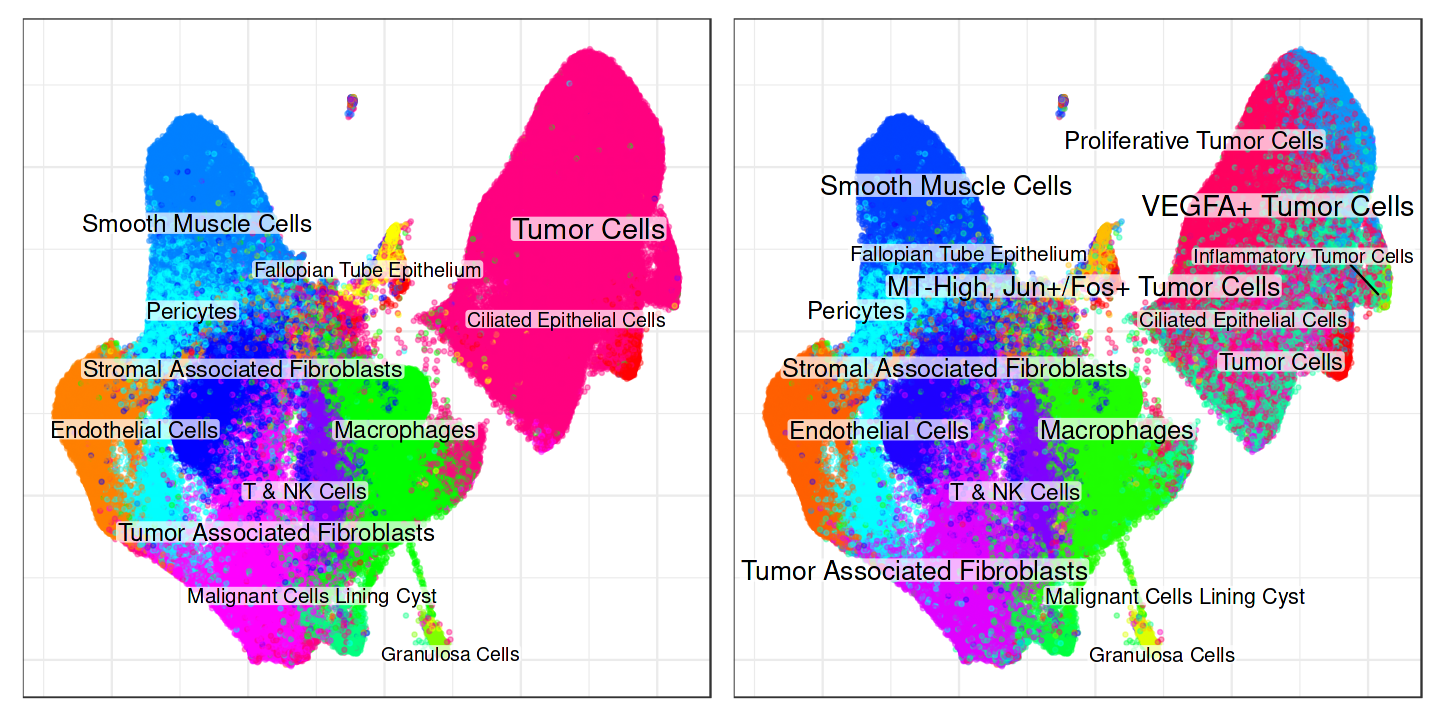

In [7]:
options(repr.plot.width=12, repr.plot.height=6)
c('cell_type', 'cell_type_full') %>% lapply(\(ct) {
  embeddingPlot(so, 'umap', groups=ct, font.size=c(4, 6))
}) %>% {.[[1]] | .[[2]]}

## Save

In [8]:
DatasetPath('human_ovarian_cancer', 'seg_method_results', 'bidcell', 'so.rds') %>% write_rds(so, .)